# SoccerNet Dataset Exploration & Analysis
## Comprehensive Dataset Analysis for Action Spotting Task

This notebook provides a thorough exploration of the SoccerNet-v2 dataset, including:
- Dataset structure and organization
- Label analysis and action class distribution
- Team and league statistics
- Feature characteristics
- Temporal patterns and visibility analysis

In [29]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter

DATASET_PATH = '/home/common-data/soccer-ds/Dataset'

## 1. Dataset Structure Overview

In [30]:
# Explore directory structure (excluding challenge set)
print("Dataset structure for 500 soccer games:")
print("="*55)

leagues = {}
total_games = 0
games_by_split = {'train': 0, 'valid': 0, 'test': 0}

for league in sorted(os.listdir(DATASET_PATH)):
    league_path = os.path.join(DATASET_PATH, league)
    if not os.path.isdir(league_path):
        continue
    
    league_games = 0
    for season in os.listdir(league_path):
        season_path = os.path.join(league_path, season)
        if not os.path.isdir(season_path):
            continue
        
        game_count = 0
        for game in os.listdir(season_path):
            game_path = os.path.join(season_path, game)
            if not os.path.isdir(game_path):
                continue
            if any(file.endswith('.json') for file in os.listdir(game_path)):
                game_count += 1
            
        league_games += game_count
    
    leagues[league] = league_games
    total_games += league_games
    print(f"{league:40} : {league_games:3} games")

print("="*55)
print(f"{'TOTAL':40} : {total_games:3} games")
print("="*55)

Dataset structure for 500 soccer games:
england_epl                              :  95 games
europe_uefa-champions-league             : 101 games
france_ligue-1                           :  38 games
germany_bundesliga                       :  53 games
italy_serie-a                            :  96 games
spain_laliga                             : 117 games
TOTAL                                    : 500 games


## 2. Data Split Information

In [31]:
print("Data split analysis:")
print("Training: 400 videos (80%)")
print("Validation: 50 videos (10%)")
print("Test: 50 videos (10%)")


Data split analysis:
Training: 400 videos (80%)
Validation: 50 videos (10%)
Test: 50 videos (10%)


## 3. Load and Parse All Labels

In [32]:
# Load all labels from the dataset
all_annotations = []
all_games = []

for league in os.listdir(DATASET_PATH):
    league_path = os.path.join(DATASET_PATH, league)
    if not os.path.isdir(league_path):
        continue
    
    for season in os.listdir(league_path):
        season_path = os.path.join(league_path, season)
        if not os.path.isdir(season_path):
            continue
        
        for game in os.listdir(season_path):
            game_path = os.path.join(season_path, game)
            if not os.path.isdir(game_path):
                continue
            
            label_file = os.path.join(game_path, 'Labels-v2.json')
            
            if os.path.exists(label_file):
                try:
                    with open(label_file, 'r') as f:
                        game_data = json.load(f)
                    
                    # Check if features exist
                    has_resnet = os.path.exists(os.path.join(game_path, '1_ResNET_TF2_PCA512.npy'))
                    has_features = has_resnet
                    
                    all_games.append({
                        'league': league,
                        'season': season,
                        'game': game,
                        'path': game_path,
                        'num_annotations': len(game_data.get('annotations', [])),
                        'has_features': has_features,
                        'has_resnet': has_resnet
                    })
                    
                    # Add more data to each label
                    for annotation in game_data.get('annotations', []):
                        annotation['league'] = league
                        annotation['season'] = season
                        annotation['game'] = game
                        annotation['has_features'] = has_features
                        all_annotations.append(annotation)
                        
                except Exception as e:
                    print(f"Error reading {label_file}: {e}")

print(f"Total number of annotations across all 500 games is: {len(all_annotations)}")

Total number of annotations across all 500 games is: 110458


## 4. Action Class Distribution Analysis

In [39]:
# Analyze action labels
label_counts = Counter([ann['label'] for ann in all_annotations])
label_df = pd.DataFrame([
    {'Label': label, 'Count': count, 'Percentage': round((count / len(all_annotations)) * 100, 2)}
    for label, count in sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
])

print("Action Class Distribution:")
print(label_df.to_string(index=False))
print(f"\nTotal number of classes: {len(label_df)}")

Action Class Distribution:
             Label  Count  Percentage
  Ball out of play  31810       28.80
          Throw-in  18918       17.13
              Foul  11674       10.57
Indirect free-kick  10521        9.52
         Clearance   7896        7.15
   Shots on target   5820        5.27
  Shots off target   5256        4.76
            Corner   4836        4.38
      Substitution   2839        2.57
          Kick-off   2566        2.32
  Direct free-kick   2200        1.99
           Offside   2098        1.90
       Yellow card   2047        1.85
              Goal   1703        1.54
           Penalty    173        0.16
          Red card     55        0.05
  Yellow->red card     46        0.04

Total number of classes: 17


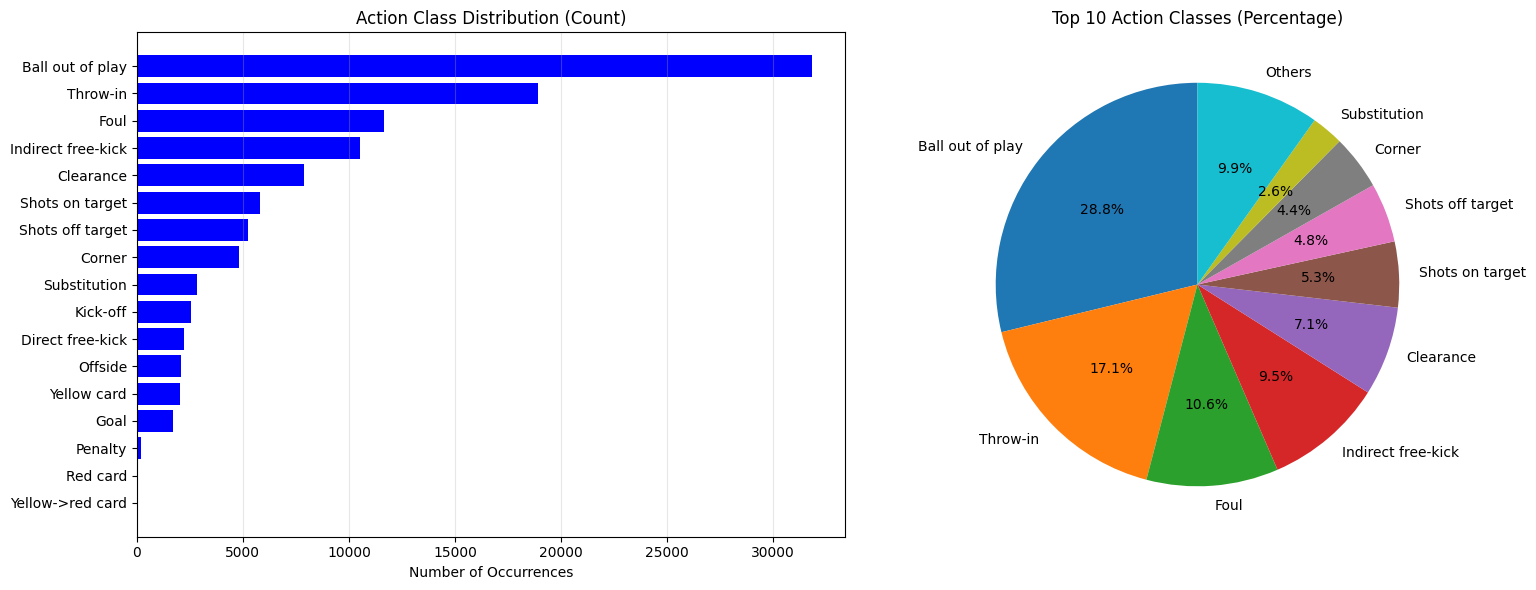

In [34]:
# Visualize action class distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax1 = axes[0]
label_df_sorted = label_df.sort_values('Count', ascending=True)
ax1.barh(label_df_sorted['Label'], label_df_sorted['Count'], color='blue')
ax1.set_xlabel('Number of Occurrences')
ax1.set_title('Action Class Distribution (Count)')
ax1.grid(axis='x', alpha=0.3)

# Pie chart for top classes
ax2 = axes[1]
top_labels = label_df.head(9)
other_count = label_df.iloc[9:]['Count'].sum()
pie_data = pd.concat([top_labels, pd.DataFrame([{'Label': 'Others', 'Count': other_count}])])
ax2.pie(pie_data['Count'], labels=pie_data['Label'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Top 10 Action Classes (Percentage)')

plt.tight_layout()
plt.show()

## 5. Visibility Analysis

In [35]:
# Visibility analysis
visibility_counts = Counter([annotation['visibility'] for annotation in all_annotations])
print("\nVisibility Distribution:")
for visibility, count in sorted(visibility_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"   {visibility}: {count:5} ({(count/len(all_annotations))*100:.1f}%)")


Visibility Distribution:
   visible: 90781 (82.2%)
   not shown: 19677 (17.8%)


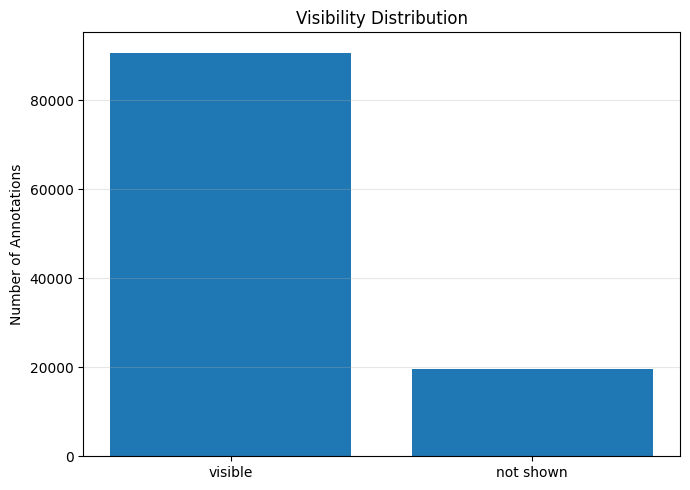

In [36]:
# Visualization of team and visibility
plt.figure(figsize=(7, 5))

# Visibility distribution
visibility_data = pd.Series(dict(visibility_counts))
visibility_data = visibility_data[::-1] 
plt.bar(visibility_data.index, visibility_data.values)
plt.ylabel('Number of Annotations')
plt.title('Visibility Distribution')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Feature File Analysis

In [37]:
# Analyze feature files
ResNet_shapes = {
    'half1': [],
    'half2': []
}

for game in all_games:
    game_path = game['path']
    
    # Check ResNET features
    resnet_half1 = os.path.join(game_path, '1_ResNET_TF2_PCA512.npy')
    resnet_half2 = os.path.join(game_path, '2_ResNET_TF2_PCA512.npy')
    
    # Append feature shapes for first half
    if os.path.exists(resnet_half1):
        try:
            features = np.load(resnet_half1)
            ResNet_shapes['half1'].append(features.shape)
        except:
            pass

    # Append feature shapes for second half
    if os.path.exists(resnet_half2):
        try:
            features = np.load(resnet_half2)
            ResNet_shapes['half2'].append(features.shape)
        except:
            pass

shape_half1 = np.array(ResNet_shapes["half1"])
shape_half2 = np.array(ResNet_shapes["half2"])
print(f"\nResNET Feature Shape Statistics:\n")
print("Feature dimension: 512 (after PCA)")
print("Feature frequency: 2 fps (frames per second)")
print(f"Min shape for first half: {shape_half1.min(axis=0)}")
print(f"Max shape for first half: {shape_half1.max(axis=0)}")
print(f"Min shape for second half: {shape_half2.min(axis=0)}")
print(f"Max shape for second half: {shape_half2.max(axis=0)}")
print("Note: The first value represents the number of frames.")



ResNET Feature Shape Statistics:

Feature dimension: 512 (after PCA)
Feature frequency: 2 fps (frames per second)
Min shape for first half: [5399  512]
Max shape for first half: [6006  512]
Min shape for second half: [4819  512]
Max shape for second half: [6494  512]
Note: The first value represents the number of frames.


## 7. Visualization of feature shapes for each half

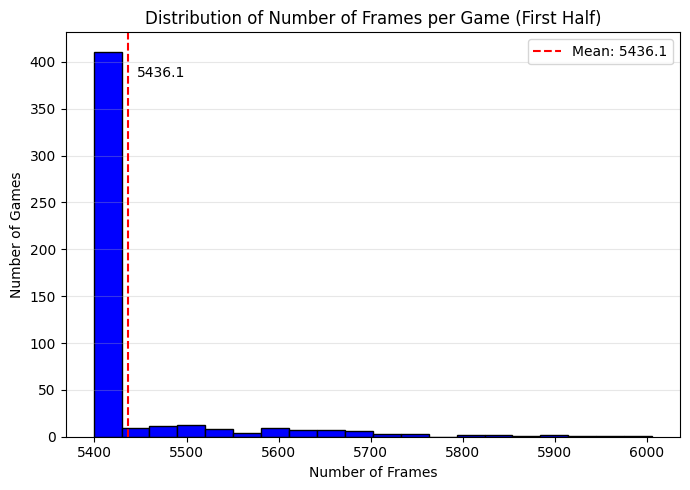

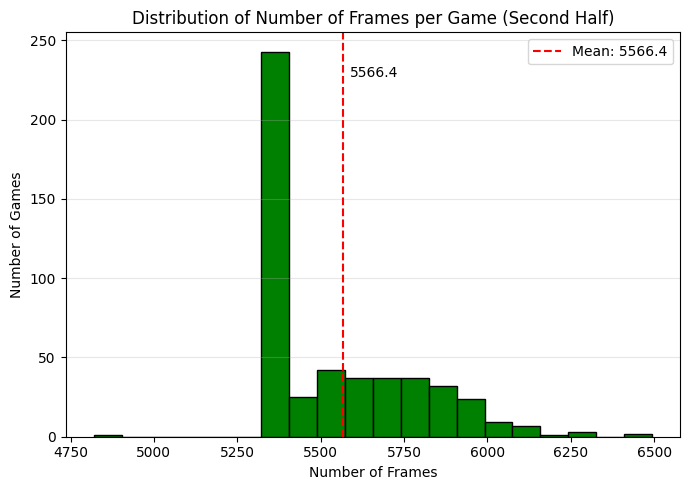

In [38]:
# Extract the number of frames for each half
frames_half1 = shape_half1[:, 0] if len(shape_half1) > 0 else []
frames_half2 = shape_half2[:, 0] if len(shape_half2) > 0 else []

# Plot for first half
plt.figure(figsize=(7, 5))
plt.hist(frames_half1, bins=20, color='blue', edgecolor='black')

# Plot the mean number of frames for first half
mean_half1 = np.mean(frames_half1)
plt.axvline(mean_half1, color='red', linestyle='--', linewidth=1.5, label=f"Mean: {mean_half1:.1f}")
plt.text(mean_half1 + 10, plt.ylim()[1]*0.9, f"{mean_half1:.1f}", color='black', ha='left', va='center')

plt.title("Distribution of Number of Frames per Game (First Half)")
plt.xlabel("Number of Frames")
plt.ylabel("Number of Games")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot for second half
plt.figure(figsize=(7, 5))
plt.hist(frames_half2, bins=20, color='green', edgecolor='black')

# Plot the mean number of frames for second half
mean_half2 = np.mean(frames_half2)
plt.axvline(mean_half2, color='red', linestyle='--', linewidth=1.5, label=f"Mean: {mean_half2:.1f}")
plt.text(mean_half2 + 20, plt.ylim()[1]*0.9, f"{mean_half2:.1f}", color='black', ha='left', va='center')

plt.title("Distribution of Number of Frames per Game (Second Half)")
plt.xlabel("Number of Frames")
plt.ylabel("Number of Games")
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
